# Verification of Elastic wave equation implementation on a staggered grid using the method of manufactured solutions.
This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, TimeAxis
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (301, 301)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 600.
dt = (10. / np.sqrt(2.)) / 6.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [1000., 1000.]
#src.show()

so = 2 # space order
vx  = TimeFunction(name='vx' , grid=grid, staggered = x,    space_order=so)
vz  = TimeFunction(name='vz' , grid=grid, staggered = z,    space_order=so)
txx = TimeFunction(name='txx', grid=grid, staggered = NODE, space_order=so)
tzz = TimeFunction(name='tzz', grid=grid, staggered = NODE, space_order=so)
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so) 

# Now let's try and create the staggered updates
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
V_s = 1.0
density = 3.

# The source injection term
src_xx = src.inject(field=txx.forward, expr=src)
src_zz = src.inject(field=tzz.forward, expr=src)

#c1 = 9.0/8.0;
#c2 = -1.0/24.0;

# Thorbecke's parameter notation
cp2 = V_p*V_p
cs2 = V_s*V_s
ro = 1/density

mu = cs2*ro
l = (cp2*ro - 2*mu)

# fdelmodc reference implementation
u_vx = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))
u_vz = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))
u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)
u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))

op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

op()

# Let's see what we got....
plot_image(vx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(vz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tzz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")

Operator `Kernel` run in 0.48 s


<Figure size 800x600 with 2 Axes>

<Figure size 800x600 with 2 Axes>

<Figure size 800x600 with 2 Axes>

<Figure size 800x600 with 2 Axes>

<Figure size 800x600 with 2 Axes>

# Analytical solution definition and  Corresponding source

In [2]:
from sympy import cos, sin, exp, pprint, sqrt, sin, sinc
import sympy

# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (310, 310)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z)) #x, z = grid.dimensions
t = grid.time_dim

u, v, w, c = sympy.symbols('u v w c')
sol = sin(2*np.pi*u) * sin(4*np.pi*v)* sin(2*np.pi*w)
#print(sol)


# Corresponding source
source = sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
print('source = sol.diff: ', source)

sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing})
print('Solution:',sol)
source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing})
print('Source:',sol)



so = 2
so2 = 0
to = 1

u = TimeFunction(name='vx',  grid=grid, staggered=x,      space_order=so, time_order=to)


vx  = TimeFunction(name='vx',  grid=grid, staggered=x,      space_order=so, time_order=to)
vz  = TimeFunction(name='vz',  grid=grid, staggered=z,      space_order=so, time_order=to)
vz  = TimeFunction(name='vz',  grid=grid, staggered=z,      space_order=so, time_order=to)
txx = TimeFunction(name='txx', grid=grid, staggered=NODE,   space_order=so, time_order=to)
tzz = TimeFunction(name='tzz', grid=grid, staggered=NODE,   space_order=so, time_order=to)
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so, time_order=to)
    
# Wave equation
vx_true  = TimeFunction(name='vx_true' , grid=grid, staggered=x,      space_order=so, time_order=to)
vz_true  = TimeFunction(name='vz_true' , grid=grid, staggered=z,      space_order=so, time_order=to)
txx_true = TimeFunction(name='txx_true', grid=grid, staggered=NODE,   space_order=so, time_order=to)
tzz_true = TimeFunction(name='tzz_true', grid=grid, staggered=NODE,   space_order=so, time_order=to)
txz_true = TimeFunction(name='txz_true', grid=grid, staggered=(x, z), space_order=so, time_order=to)
    
src_vx  = TimeFunction(name='src_vx' , grid=grid, staggered=x,     space_order=so, time_order=to)
src_vz  = TimeFunction(name='src_vz' , grid=grid, staggered=z,     space_order=so, time_order=to)
src_txx = TimeFunction(name='src_txx', grid=grid, staggered=NODE,  space_order=so, time_order=to)
src_tzz = TimeFunction(name='src_tzz', grid=grid, staggered=NODE,  space_order=so, time_order=to)
src_txz = TimeFunction(name='src_txz', grid=grid, staggered=(x, z),space_order=so, time_order=to)
    
#print(':', vx)
#print(':', vx_true)
#print(':', src_vx)
    
# fdelmodc reference implementation
wave_vx  = Eq(vx.forward,  vx - dt*ro*(txx.dx + txz.dz + src_vx ) )
wave_vz  = Eq(vz.forward,  vz - ro*dt*(txz.dx + tzz.dz + src_vz) )
wave_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz - dt*src_txx )
wave_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx - dt*src_tzz   )
wave_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx)   - dt*src_txz   )

print('wave_vx :', wave_vx)


true_eqq_vx  = Eq(vx_true, sol)
true_eqq_vz  = Eq(vz_true, sol)
true_eqq_txx = Eq(txx_true, sol)
true_eqq_txz = Eq(txz_true, sol)
true_eqq_tzz = Eq(tzz_true, sol)

print('true_eqq_vx :', true_eqq_vx)


src_eq_vx  = Eq( src_vx , source)
src_eq_vz  = Eq( src_vz , source)
src_eq_txx = Eq( src_txx, source)
src_eq_txz = Eq( src_txz, source)
src_eq_tzz = Eq( src_tzz, source)

print('src_eq_vx :', src_eq_vx)


## from devito import configuration
configuration["log-level"] = "ERROR"
h = .00125

#print('u : ',u)
#print('---------------')
#print('vx : ', vx)
#print('---------------')
vx_0 = Eq(vx , sol )
#print('vx 0: ', vx_0)
vx_1 = Eq(vx.subs(t, 1), sol.subs(t, 1))
#print('vx_1 : ', vx_1)
#print('true_eqq_vx : ', true_eqq_vx)
#print('src_eq_vx : ', src_eq_vx)
#print(' wave_vx : ', wave_vx)
#print('---------------')

op = Operator([vx_1,true_eqq_vx, src_eq_vx, wave_vx], subs=({t.spacing: .1*h, x.spacing:h, z.spacing:h}))
op.apply(t_m=0, t_M=600)

#print('vx_1', vx_1)
#print('true_eqq_vx : ', true_eqq_vx)
#print('src_eq_vx : ', src_eq_vx)
#print(' wave_vx : ', wave_vx)

source = sol.diff:  157.91367041743*sin(6.28318530717959*u)*sin(12.5663706143592*v)*sin(6.28318530717959*w)
Solution: sin(6.28318530717959*x*h_x)*sin(12.5663706143592*z*h_z)*sin(6.28318530717959*time*dt)
Source: sin(6.28318530717959*x*h_x)*sin(12.5663706143592*z*h_z)*sin(6.28318530717959*time*dt)
wave_vx : Eq(vx(t + dt, x, z), -0.392837100659193*src_vx(t, x, z) + vx(t, x, z) + 0.392837100659193*txz(t, x, z)/h_z - 0.392837100659193*txz(t, x, z + h_z)/h_z - 0.392837100659193*txx(t, x, z)/h_x + 0.392837100659193*txx(t, x - h_x, z)/h_x)
true_eqq_vx : Eq(vx_true(t, x, z), sin(6.28318530717959*x*h_x)*sin(12.5663706143592*z*h_z)*sin(6.28318530717959*time*dt))
src_eq_vx : Eq(src_vx(t, x, z), 157.91367041743*sin(6.28318530717959*x*h_x)*sin(12.5663706143592*z*h_z)*sin(6.28318530717959*time*dt))


PerformanceSummary([('section0',
  PerfEntry(time=3.5028499999999974, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

# Elastic wave equation

In [3]:
def get_solution_elastic(size, space_order):
    clear_cache()
    import sympy
    from sympy import cos, sin, exp, pprint, sqrt, sin, sinc
    
    
    # Initial grid: 1km x 1km, with spacing 100m
    extent = (2000., 2000.)
    shape = (size, size)
    x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
    z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
    grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

    # Grid
    h = 1./(size - 1)
    
    # Now let's try and create the staggered updates
    t = grid.stepping_dim
    time = grid.time_dim

    # We need some initial conditions
    V_p = 4.0
    V_s = 1.0
    density = 3.

    # The source injection term
    #src_xx = src.inject(field=txx.forward, expr=src)
    #src_zz = src.inject(field=tzz.forward, expr=src)

    # Thorbecke's parameter notation
    cp2 = V_p*V_p
    cs2 = V_s*V_s
    ro = 1/density
    mu = cs2*ro
    l = (cp2*ro - 2*mu)

    # fdelmodc reference implementation
    #u_vx = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))
    #u_vz = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))
    #u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
    #u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)
    #u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))

    # Timestep size from Eq. 7 with V_p=6000. and dx=100
    t0, tn = 0., 100.

    #dt = (10. / np.sqrt(2.)) / 40.
    dt= 1.5
    time_range = TimeAxis(start=t0, stop=tn, step=dt)
    src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
    src.coordinates.data[:] = [1000., 1000.]
    
    nt = 68;   # FIX ME
    
    # Now we create the velocity and pressure fields
    so = space_order
    so2 = so
    
    vx  = TimeFunction(name='vx',  grid=grid, staggered=x,      space_order=so,  save=nt)
    vz  = TimeFunction(name='vz',  grid=grid, staggered=z,      space_order=so,  save=nt)
    txx = TimeFunction(name='txx', grid=grid, staggered=NODE,   space_order=so,  save=nt)
    tzz = TimeFunction(name='tzz', grid=grid, staggered=NODE,   space_order=so,  save=nt)
    txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so,  save=nt)
    
    # The source injection term
    src_xx = src.inject(field=txx.forward, expr=src)
    src_zz = src.inject(field=tzz.forward, expr=src)
    
    # Wave equation
    vx_true  = TimeFunction(name='vx_true' , grid=grid, staggered=x,      space_order=so2,  save=nt)
    vz_true  = TimeFunction(name='vz_true' , grid=grid, staggered=z,      space_order=so2,  save=nt)
    txx_true = TimeFunction(name='txx_true', grid=grid, staggered=NODE,   space_order=so2,  save=nt)
    tzz_true = TimeFunction(name='tzz_true', grid=grid, staggered=NODE,   space_order=so2,  save=nt)
    txz_true = TimeFunction(name='txz_true', grid=grid, staggered=(x, z), space_order=so2,  save=nt)
     
    src_vx  = TimeFunction(name='src_vx' , grid=grid, staggered=x,     space_order=so2,  save=nt)
    src_vz  = TimeFunction(name='src_vz' , grid=grid, staggered=z,      space_order=so2, save=nt)
    src_txx = TimeFunction(name='src_txx', grid=grid, staggered=NODE,   space_order=so2, save=nt)
    src_tzz = TimeFunction(name='src_tzz', grid=grid, staggered=NODE,   space_order=so2, save=nt)
    src_txz = TimeFunction(name='src_txz', grid=grid, staggered=(x, z), space_order=so2, save=nt)
    
    
    ###################input = ###########################################################

    t = time
    
    #t=dt
    
    
    u, v, w, c = sympy.symbols('u v w c')
    #sol = 1e1*sin(2*np.pi*u) * sin(4*np.pi*v)* sin(6*np.pi*w)
    sol = (100*sin(6*np.pi*w) * exp(-(u - .5)**2/.015 - (v-.5)**2/.015) -
           100*sin(4*np.pi*w) *exp(-(u - .45)**2/.0025 - (v-.65)**2/.0025)-
           50*sin(8*np.pi*w) *exp(-(u - .65)**2/.0025 - (v-.45)**2/.0015)-
           100*sin(6*np.pi*w) * exp(-(u - .45)**2/.0015 - (v-.45)**2/.0025)-
           500*sin(6*np.pi*w) * exp(-(u - .65)**2/.0027 - (v-.65)**2/.0021))
    #print(sol)

    # Corresponding source
    source = sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    #print('Source : ', source)

    sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing})
    #print('Solution : ',sol)
    source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing})
    #print('Source : ', source)

    #################################################################################
    
    # fdelmodc reference implementation
    wave_vx  = Eq(vx.forward,  vx - dt*ro*(txx.dx + txz.dz + src_vx)                  )
    wave_vz  = Eq(vz.forward,  vz - ro*dt*(txz.dx + tzz.dz + src_vz)                  )
    wave_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz  - dt*src_txx)
    wave_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx  - dt*src_tzz )
    wave_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx)             - mu*dt*src_txz )

    true_eqq_vx  = Eq(vx_true, sol)
    true_eqq_vz  = Eq(vz_true, sol)
    true_eqq_txx = Eq(txx_true, sol)
    true_eqq_txz = Eq(txz_true, sol)
    true_eqq_tzz = Eq(tzz_true, sol)
    #print(true_eqq_vx)


    src_eq_vx  = Eq( src_vx , source)
    src_eq_vz  = Eq( src_vz , source)
    src_eq_txx = Eq( src_txx, source)
    src_eq_txz = Eq( src_txz, source)
    src_eq_tzz = Eq( src_tzz, source)
    
    
    configuration["log-level"] = "ERROR"
    
    vx_1 = Eq(vx.subs(t, 1), sol.subs(t, 1))
    vz_1 = Eq(vz.subs(t, 1), sol.subs(t, 1))
    txx_1 = Eq(txx.subs(t, 1), sol.subs(t, 1))
    txz_1 = Eq(txz.subs(t, 1), sol.subs(t, 1))
    tzz_1 = Eq(tzz.subs(t, 1), sol.subs(t, 1))
    
    
    
    #print('vx_1 : ', vx_1)
    #print('true_eqq_vx : ', true_eqq_vx)
    #print('src_eq_vx : ', src_eq_vx)
    #print(' wave_vx : ', wave_vx)
    #print('---------------')
    #op = Operator([vx_1, vz_1, txx_1, tzz_1, txz_1])


    #op = Operator([vx_1,true_eqq_vx, src_eq_vx, wave_vx]+ src_xx + src_zz, subs=({t.spacing: .1*h, x.spacing:h, z.spacing:h}))
    op = Operator([vx_1,vz_1,txx_1,txz_1,tzz_1,
                   wave_vx, wave_vz, wave_txx, wave_tzz, wave_txz,
                   true_eqq_vx, true_eqq_vz, true_eqq_txx,true_eqq_txz,true_eqq_tzz,
                   src_eq_vx,src_eq_vz,src_eq_txx,src_eq_txz,src_eq_tzz] + src_xx + src_zz
                   #,
                   #subs=({t.spacing:.1*h, x.spacing:h, z.spacing:h})
                   )

    
    #### IMPORTANT NOTE TO FIX
    # Using subs we do damage to the equations of our model but we screw up our analytical sources
    
    # Reset the fields
    #vx.data[:] = 0.
    #vz.data[:] = 0.
    #txx.data[:] = 0.
    #tzz.data[:] = 0.
    #txz.data[:] = 0.
    
    op.apply()
    #op.apply(t_m=1, t_M=600)
    
    
    
    
    error1 = np.linalg.norm(vx.data[(nt-3), :, :].reshape(-1) -
                            vx_true.data[(nt-3), :, :].reshape(-1), 2)*h
    error2 = np.linalg.norm(vz.data[(nt-3), :, :].reshape(-1) -
                            vz_true.data[(nt-3), :, :].reshape(-1), 2)*h
    error3 = np.linalg.norm(txx.data[(nt-3), :, :].reshape(-1) -
                            txx_true.data[(nt-3), :, :].reshape(-1), 2)*h
    error4 = np.linalg.norm(txz.data[(nt-3), :, :].reshape(-1) -
                           txz_true.data[(nt-3), :, :].reshape(-1), 2)*h
    error5 = np.linalg.norm(tzz.data[(nt-3), :, :].reshape(-1) -
                           tzz_true.data[(nt-3), :, :].reshape(-1), 2)*h
    
    error = (error1 + error2 + error3 + error4 +error5) / 5
    #print("for h = %f and dt= %2.2e ms error1 is %2.4e error2 is %2.4e error3 is %2.4e" % (h, dt, error1,error2,error3))
    print("Size = %d and space_order = %d " % (size, so))
    print("for h = %f and dt= %2.2e ms error is %2.4e" % (h, dt, error))
     
    if(1):
        import matplotlib.pyplot as plt
        plt.figure()
        plt.subplot(131)
        plt.imshow(vx.data[(nt-3), :, :], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
        plt.subplot(132)
        plt.imshow(vx_true.data[(nt-3), :, :], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
        plt.subplot(133)
        plt.imshow(vx.data[(nt-3), :, :] - vx_true.data[(nt-3), :, :],vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
        plt.show()

    return error

# MMS

Size = 51 and space_order = 2 
for h = 0.020000 and dt= 1.50e+00 ms error is 8.5197e-02


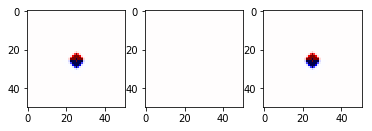

Size = 51 and space_order = 4 
for h = 0.020000 and dt= 1.50e+00 ms error is 8.2150e-02


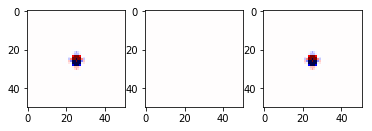

Size = 51 and space_order = 6 
for h = 0.020000 and dt= 1.50e+00 ms error is 8.0197e-02


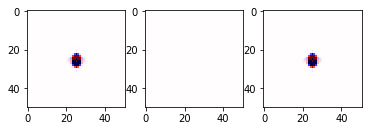

Size = 51 and space_order = 8 
for h = 0.020000 and dt= 1.50e+00 ms error is 7.9033e-02


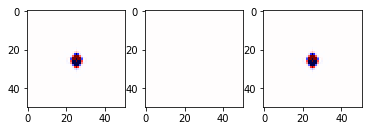

Size = 51 and space_order = 10 
for h = 0.020000 and dt= 1.50e+00 ms error is 7.8279e-02


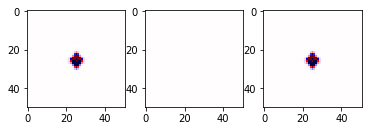

Size = 75 and space_order = 2 
for h = 0.013514 and dt= 1.50e+00 ms error is 4.7142e-02


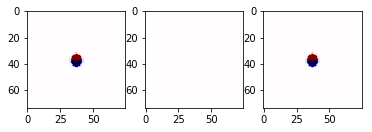

Size = 75 and space_order = 4 
for h = 0.013514 and dt= 1.50e+00 ms error is 4.1495e-02


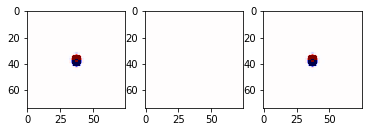

Size = 75 and space_order = 6 
for h = 0.013514 and dt= 1.50e+00 ms error is 3.9827e-02


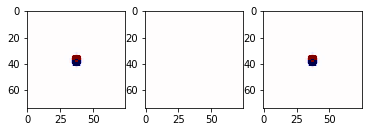

Size = 75 and space_order = 8 
for h = 0.013514 and dt= 1.50e+00 ms error is 3.9111e-02


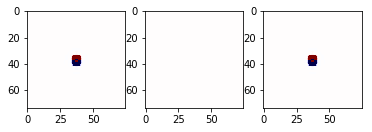

Size = 75 and space_order = 10 
for h = 0.013514 and dt= 1.50e+00 ms error is 3.8736e-02


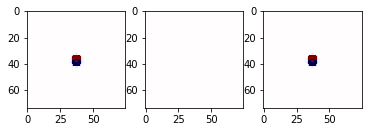

Size = 101 and space_order = 2 
for h = 0.010000 and dt= 1.50e+00 ms error is 2.4724e-02


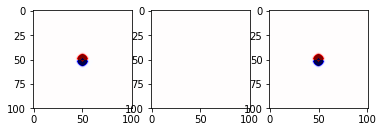

Size = 101 and space_order = 4 
for h = 0.010000 and dt= 1.50e+00 ms error is 2.2209e-02


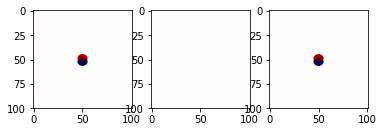

Size = 101 and space_order = 6 
for h = 0.010000 and dt= 1.50e+00 ms error is 2.1693e-02


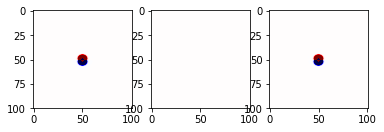

Size = 101 and space_order = 8 
for h = 0.010000 and dt= 1.50e+00 ms error is 2.1513e-02


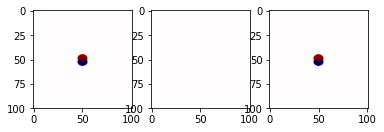

Size = 101 and space_order = 10 
for h = 0.010000 and dt= 1.50e+00 ms error is 2.1430e-02


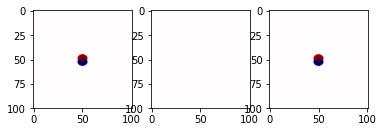

In [4]:
#size = [51, 75, 101, 151, 201, 301, 401]
size = [51, 75, 101]

#t = 2
so = [2, 4 , 6, 8, 10]
error = np.zeros((len(size), len(so)))
# hh = [4*h for h in hh]
for i, s in enumerate(size):
    for j, sso in enumerate(so):
        error[i, j] = get_solution_elastic(s, sso)

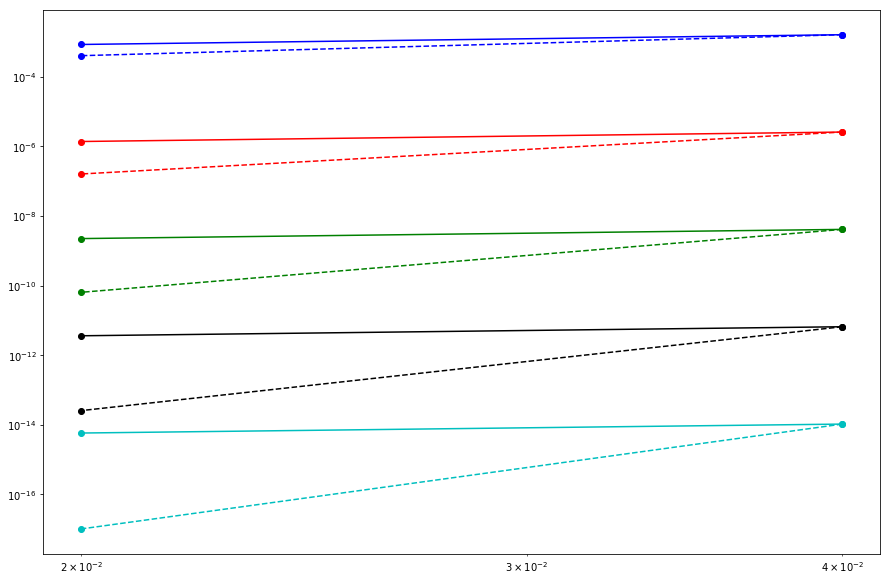

In [5]:
import matplotlib.pyplot as plt
col = ['-ob', '-or', '-og', '-ok', '-oc']
col_2 = ['--ob', '--or', '--og', '--ok', '--oc']
#hh = [0.02, 0.01, 0.005, 0.00025]
#hh = [1, .5, .25, .125]
#hh = [4*h for h in hh]
#hh = [0.02, 0.01, 0.005, 0.0025, 0.00125]
hh = [0.08, 0.04, 0.02, 0.01, 0.005, 0.0025, 0.00125]

plt.figure(figsize=(15, 10))
for j, sso in enumerate(so):
    plt.loglog(hh[1:3], hh[1]**so[j]*error[1:3, j]/error[1, j], col[j])
    plt.loglog(hh[1:3], [h**so[j] for h in hh][1:3], col_2[j])

    #plt.loglog(hh[1:3], error[:, 3])
    #plt.loglog(hh[1:3], [h**so[3] for h in hh])

Text(0.5, 0, 'Space order')

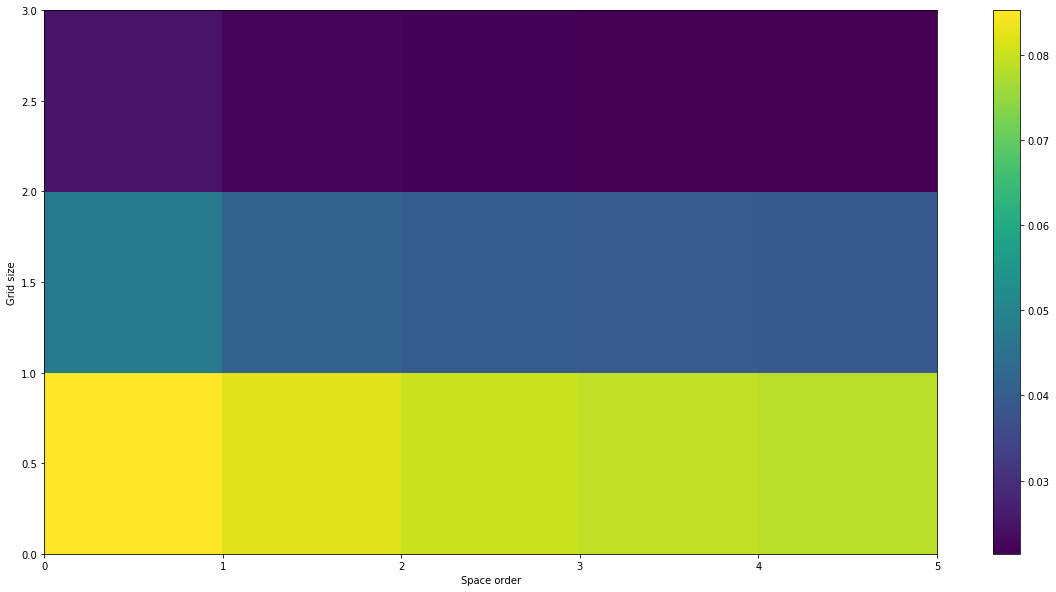

In [6]:
fig = plt.figure(figsize=(20, 10))
im = plt.pcolormesh(error)
fig.colorbar(im)
plt.ylabel('Grid size')
plt.xlabel('Space order')